In [1]:
# Load dataset
import pandas as pd

df = pd.read_csv('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

In [4]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    w1 = WordNetLemmatizer()

    soup = BeautifulSoup(text, "html.parser")  # Removing html tags
    text = soup.get_text()

    text = expand_contractions(text)  # Expanding contractions

    # Removing emojis
    emoji_clean = re.compile("["
                             u"\U0001F600-\U0001F64F"  # emoticons
                             u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                             u"\U0001F680-\U0001F6FF"  # transport & map symbols
                             u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                             u"\U00002500-\U00002B7F"  # Geometric Shapes
                             u"\U000024C2-\U0001F251"  # Enclosed characters
                             "]+", flags=re.UNICODE)
    
    text = emoji_clean.sub(r'', text)

    text = re.sub(r'\.(?=\S)', '. ', text)  # Add space after full stops
    text = re.sub(r'http\S+', '', text)  # Remove URLs

    # Remove punctuation and convert to lowercase
    text = "".join([word.lower() for word in text if word not in string.punctuation])

    # Lemmatization and stopwords removal
    text = " ".join([w1.lemmatize(word) for word in text.split() 
                     if word not in stop and word.isalpha()])

    return text

# Applying the function to a dataframe column
df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quang\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\quang\AppData\Local\Temp\ipykernel_22068\1371395140.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")  # Removing html tags


C:\Users\quang\AppData\Local\Temp\ipykernel_22068\3197519219.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pie.show()


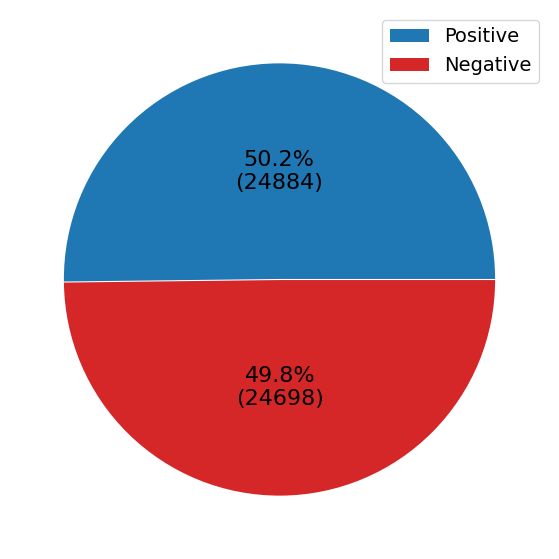

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating autocpt arguments
def func(pct, allvalues):
    abs = int(np.round(pct/100.*np.sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, abs)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

label = ['positive', 'negative']

pie, ax = plt.subplots(figsize=[11,7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2, 
        pctdistance =0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize': 16})
labels = [r'Positive', r'Negative']
plt.legend(labels, loc="best", prop={'size': 14})
pie.show()

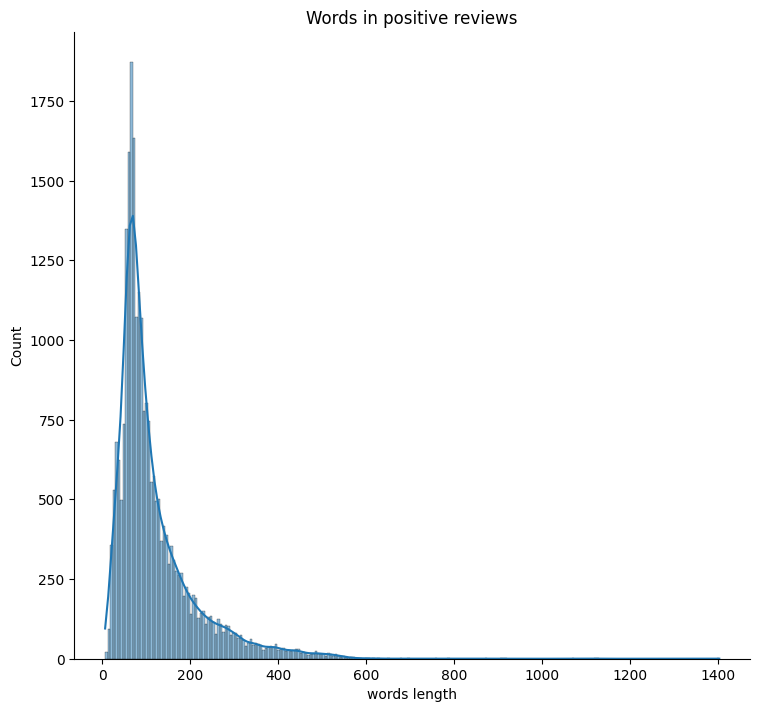

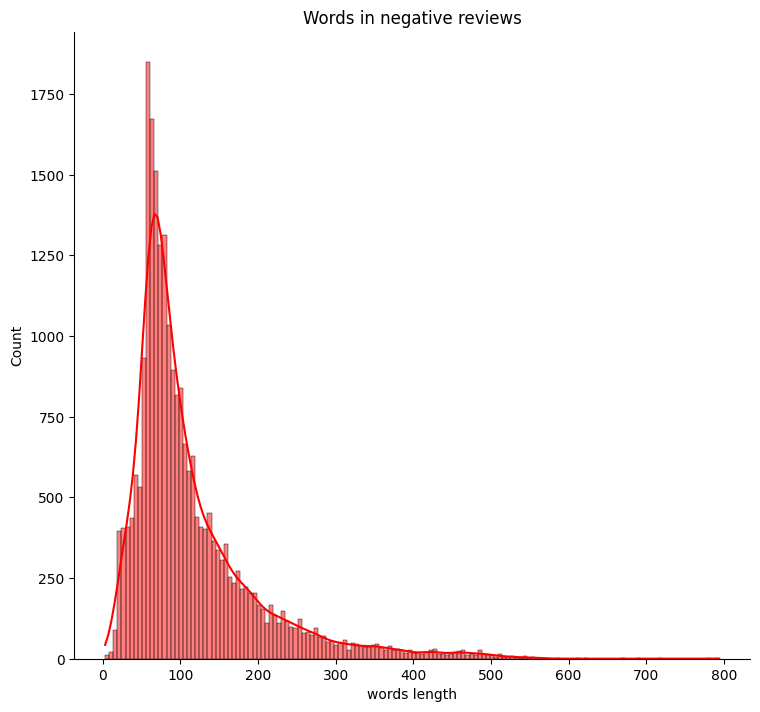

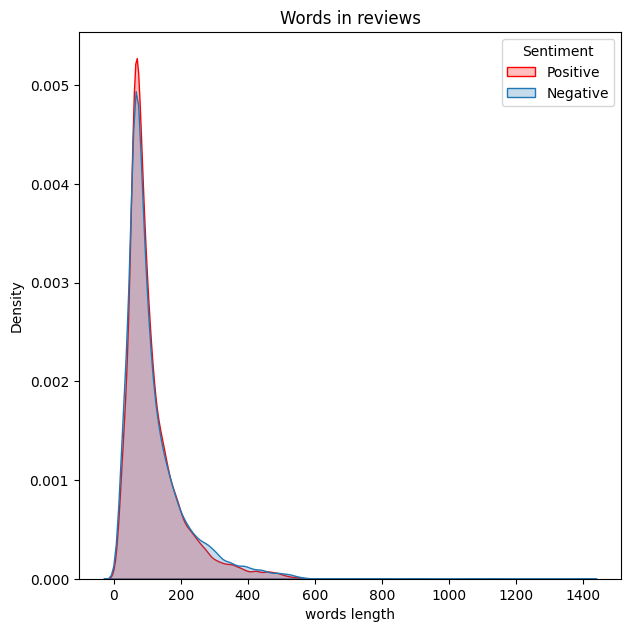

In [9]:
words_len = df['review'].str.split().map(lambda x: len(x))  
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde = True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde = True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['Positive', 'Negative'])
plt.show(kernel_distribution_number_words_plot) 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(df['review'], y_data, test_size=0.2, random_state=42)

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [13]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_test, y_pred)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_test, y_pred)

0.8420893415347384